# GPM data pre-processing

* GPM: daily precip research/final run (`GPM_L3`) is selected, details see: https://pmm.nasa.gov/data-access/downloads/gpm
* Data browsed and downloaded from NASA OpenDAP: https://gpm1.gesdisc.eosdis.nasa.gov/opendap/
* OpenDAP supports variable selection, domain truncation and netCDF4 conversion.
* Truncated data: https://drive.google.com/file/d/1lTUPrmH3j-9Ep6CUXrwncFIcUgw-UMOI/view?usp=sharing
* All the files in Nov 2017 are accessed and Nov 21st is selected for significant precipitation events


In [1]:
from glob import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
nc_name = glob('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/GPM_BC/*.nc4')
nc_base = glob('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/*.nc4')

# GPM metadata

In [3]:
nc.Dataset(nc_base[0])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    BeginDate: 2017-11-01
    BeginTime: 00:00:00.000Z
    EndDate: 2017-11-01
    EndTime: 23:59:59.999Z
    FileHeader: StartGranuleDateTime=2017-11-01T00:00:00.000Z;
StopGranuleDateTime=2017-11-01T23:59:59.999Z
    InputPointer: 3B-HHR.MS.MRG.3IMERG.20171101-S000000-E002959.0000.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S003000-E005959.0030.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S010000-E012959.0060.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S013000-E015959.0090.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S020000-E022959.0120.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S023000-E025959.0150.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S030000-E032959.0180.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S033000-E035959.0210.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S040000-E042959.0240.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S043000-E045959.0270.V05B.HDF5;3B-HHR.MS.MRG.3IMERG.20171101-S050000-E052959.0300.V05B.HDF5;3B-

# Data pre-processing

**Select domain and time**

In [4]:
with nc.Dataset(nc_base[0]) as nc_obj:
    x = nc_obj.variables['lon'][...]
    y = nc_obj.variables['lat'][...]
# lon/lat in BC
ind_left = int(np.searchsorted(x, -140, 'left'))
ind_right = int(np.searchsorted(x, -110, 'right'))
ind_bot = int(np.searchsorted(y, 48, 'left'))
ind_top = int(np.searchsorted(y, 62.5, 'right'))
lon, lat = np.meshgrid(x[ind_left:ind_right], y[ind_bot:ind_top])

In [5]:
GPM = np.empty((30,)+lon.shape)
ERROR = np.empty(GPM.shape)
for i, name in enumerate(nc_name):
    with nc.Dataset(name) as nc_obj:
        GPM[i, ...] = nc_obj.variables['HQprecipitation'][:-1, :-1].T
        ERROR[i, ...] = nc_obj.variables['randomError'][:-1, :-1].T

By domain average, index 21 (Nov 21st) has the highest precipitation, thus selected

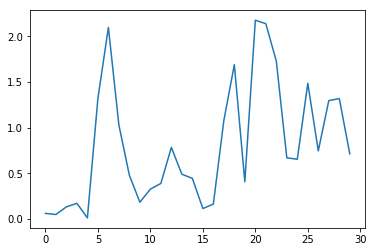

In [6]:
plt.plot(GPM.mean(axis=(1, 2)))

**Plotting**

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

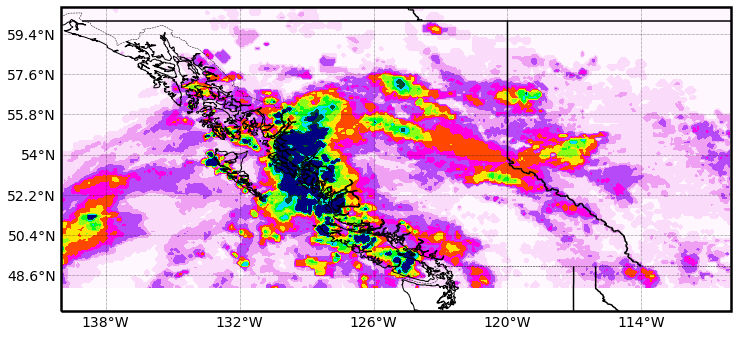

In [8]:
clevel = np.array([0, 1, 2, 3.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])

fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax = fig.gca(projection=ccrs.PlateCarree())
ax.set_extent([-140, -110, 47, 60], ccrs.Geodetic())

scale_param = '10m' # 10m for publication quality 
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
#ax.add_feature(cfeature.OCEAN.with_scale(scale_param))
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=0.5, zorder=5)
# ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='b', zorder=5)
# ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.25, edgecolor='b', zorder=5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
ax.outline_patch.set_linewidth(2.5)

GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
             linewidth=0.5, color='k', linestyle=':')

GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GL.yformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}

ax.contourf(lon, lat, GPM[21, ...], clevel, cmap=plt.cm.gist_ncar_r, extend='both')

**Get elevation from ETOPO5**

In [12]:
nc_obj = nc.Dataset('/Users/yingkai/Repository/WRFT/_data/Reanalysis/ETOPO/etopo5.nc')

In [21]:
topo_x = nc_obj.variables['topo_lon'][...]
topo_y = nc_obj.variables['topo_lat'][...]
topo = nc_obj.variables['topo'][...].astype(float)
topo_lon, topo_lat = np.meshgrid(topo_x, topo_y)

In [23]:
from scipy.interpolate import griddata

In [24]:
input_points = (topo_lon.flatten(), topo_lat.flatten())
topo_BC = griddata(input_points, topo.flatten(), (lon, lat), method='linear')

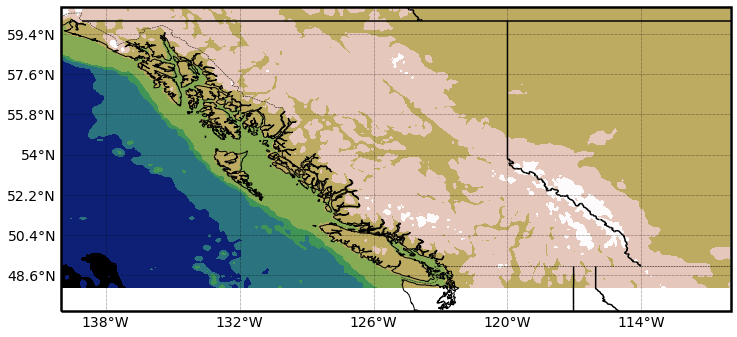

In [25]:
fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax = fig.gca(projection=ccrs.PlateCarree())
ax.set_extent([-140, -110, 47, 60], ccrs.Geodetic())

scale_param = '10m' # 10m for publication quality 
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
#ax.add_feature(cfeature.OCEAN.with_scale(scale_param))
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=0.5, zorder=5)
# ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='b', zorder=5)
# ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.25, edgecolor='b', zorder=5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
ax.outline_patch.set_linewidth(2.5)

GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=0.5, color='k', linestyle=':')

GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GL.yformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}

ax.contourf(lon, lat, topo_BC, cmap=plt.cm.gist_earth, extend='both')

# Save

In [26]:
save_dict = {'lon':lon, 'lat':lat, 'GPM':GPM, 'ERROR':ERROR, 'TOPO':topo_BC}
np.save('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/GPM_BC_Nov_2017.npy', save_dict)